# Setup

In [ ]:
import pandas as pd
import numpy as np
import math, torch
from transformers import CamembertTokenizer
from transformers.models.camembert.modeling_camembert import CamembertForSequenceClassification
from datasets import load_metric
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
device = torch.device('cuda:0')
print("Device: {}".format(device))

Device: cuda:0


# Load data and final processing

### Import and process the translated PDTB
The PDTB is freely available at: https://github.com/cgpotts/pdtb2.
It was machine-translated from French to English using the open-source LibreTranslate API: https://libretranslate.com/?source=en&target=fr&q=

In [ ]:
pdtb = pd.read_csv('drive/MyDrive/Thesis/data/pdtb_translated.csv')

#Drop if translation is error
pdtb = pdtb[pdtb['clean_text_fr'] != 'Error']

#Slice the 2 arguments from the translation
pdtb['arg1_fr'] = pdtb['clean_text_fr'].apply(lambda x: x.split('\n')[0] if len(x.split('\n'))==2 else 'Error')
pdtb['arg2_fr'] = pdtb['clean_text_fr'].apply(lambda x: x.split('\n')[1] if len(x.split('\n'))==2 else 'Error')
pdtb = pdtb[(pdtb['arg1_fr']!='Error') & (pdtb['arg2_fr']!='Error')]

#Cleaning of pdtb

#Replace the badly decoded apostrophe
pdtb['arg1_fr'] = pdtb['arg1_fr'].apply(lambda x: x.replace(' &apos; ', "'" ))
pdtb['arg2_fr'] = pdtb['arg2_fr'].apply(lambda x: x.replace(' &apos; ', "'" ))

#Remove punctuation at the begining of the argument
pdtb['arg1_fr'] = pdtb['arg1_fr'].apply(lambda x: x[1:].strip() if (x[0]=='.' or x[0]==',' or x[0]==';' or x[0]==':') else x)
pdtb['arg2_fr'] = pdtb['arg2_fr'].apply(lambda x: x[1:].strip() if (x[0]=='.' or x[0]==',' or x[0]==';' or x[0]==':') else x)

#Binary variable to identify explicit relations
pdtb['explicit'] = 0
pdtb.loc[pdtb['Connective_RawText'].isna()==False, 'explicit'] = 1

### Import and process the French corpus Explicadis

In [ ]:
explicadis = pd.read_excel('drive/My Drive/Thesis/data/explicadis_final.xlsx')

#Clean explicadis
explicadis['Arg1_raw'] = explicadis['Arg1_raw'].apply(lambda x: x.strip())
explicadis['Arg2_raw'] = explicadis['Arg2_raw'].apply(lambda x: x.strip())

explicadis['causal_type'] = 'Not causal'
explicadis.loc[explicadis['relation_type']=='result', 'causal_type'] = 'Result'
explicadis.loc[explicadis['relation_type']=='explanation', 'causal_type'] = 'Reason'

###The PDTB is split into a training, a validation and a test dataset

In [ ]:
#The PDBT is shuffled randomly
pdtb = pdtb.sample(frac=1, random_state=73940)
pdtb.reset_index(inplace=True)

train_frac = 0.70
val_frac = 0.15
test_frac = 0.15

train_slice = math.floor(pdtb.shape[0]*train_frac)
val_slice = train_slice + math.floor(pdtb.shape[0]*val_frac)
test_slice = pdtb.shape[0]+1

pdtb_train = pdtb.loc[0:train_slice, :]
pdtb_val = pdtb.loc[train_slice+1: val_slice, :]
pdtb_test = pdtb.loc[val_slice+1:test_slice, :]

print(pdtb_train.shape)
print(pdtb_val.shape)
print(pdtb_test.shape)

Formating of the data and the targets

In [ ]:
#PDTB train dataset
X_train_arg1 = pdtb_train['arg1_fr'].tolist()
X_train_arg2 = pdtb_train['arg2_fr'].tolist()
y_train = pdtb_train['causal_type'].tolist()

#Fraction of the PDTB train dataset for fine-tuning
X_train_ft_arg1 = X_train_arg1[0:10000]
X_train_ft_arg2 = X_train_arg2[0:10000]
y_train_ft = y_train[0:10000]

#PDTB validation dataset
X_val_arg1 = pdtb_val['arg1_fr'].tolist()
X_val_arg2 = pdtb_val['arg2_fr'].tolist()
y_val = pdtb_val['causal_type'].tolist()

#PDTB test dataset
X_test_arg1 = pdtb_test['arg1_fr'].tolist()
X_test_arg2 = pdtb_test['arg2_fr'].tolist()
y_test = pdtb_test['causal_type'].tolist()

#Explicadis dataset
X_explicadis_arg1 = explicadis['Arg1_raw'].tolist()
X_explicadis_arg2 = explicadis['Arg2_raw'].tolist()
y_explicadis = explicadis['causal_type'].tolist()

# Encoding

The target is encoded for the three classes:


*   0: Not causal
*   1: Reason
*   2: Result






In [ ]:
#Target encoding
y_train_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_train]
y_train_ft_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_train_ft]
y_val_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_val]
y_test_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_test]
y_explicadis_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_explicadis]

The tokenizer is specific to the camembert-large model, a BERT model for French, available at: https://camembert-model.fr/

In [ ]:
tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-large")

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456 [00:00<?, ?B/s]

Argument pairs are encoded and their length are normalized to a total of 200 tokens for the entire argument pair

In [ ]:
X_train_encoded = tokenizer(X_train_arg1, X_train_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')
X_train_ft_encoded = tokenizer(X_train_ft_arg1, X_train_ft_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')
X_val_encoded = tokenizer(X_val_arg1, X_val_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')
X_test_encoded = tokenizer(X_test_arg1, X_test_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')
X_explicadis_encoded = tokenizer(X_explicadis_arg1, X_explicadis_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')

The encoded argument pairs are loaded in a Dataset object as per HuggingFace's Transfromers library documentation: https://huggingface.co/course/chapter3/2?fw=pt

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(X_train_encoded, y_train_encoded)
train_ft_dataset = Dataset(X_train_ft_encoded, y_train_ft_encoded)
val_dataset = Dataset(X_val_encoded, y_val_encoded)
test_dataset = Dataset(X_test_encoded, [0]*len(y_test_encoded))
explicadis_dataset = Dataset(X_explicadis_encoded, [0]*len(y_explicadis_encoded))

# Fine tuning and model training

The learning rate and the weight decay (L2 regularization) are finetuned using a gridsearch approach for the following values:

*   Learning rate: 0.000001, 0.000005, 0.00001
*   Weight decay: 0.001, 0.01, 0.1



The best performing hyperparameters are a learning rate: 0.00001 and weight decay: 0.1 over 4 epochs

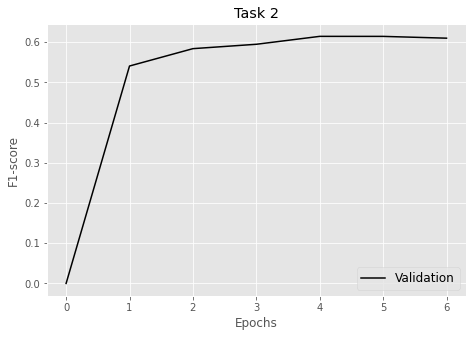

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize = (7.5, 5))
plt.plot(val_f1_history, label='Validation', color='black')
plt.legend(loc="lower right", prop={"size":12})
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('Task 2')
plt.savefig('drive/My Drive/Thesis/models/Bert threeway/bert_threeway_training_overfitted', dpi=150, fontsize=16, bbox_inches='tight')
plt.show()

The pre-trained French BERT model CamemBERT is loaded: https://camembert-model.fr/

In [ ]:
model = CamembertForSequenceClassification.from_pretrained("camembert/camembert-large", num_labels=3)

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert/camembert-large were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['cl

A F1-score metric function is defined

In [ ]:
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average=None)

A trainer object is defined

In [ ]:
training_args = TrainingArguments(
    num_train_epochs=4,             # total # of training epochs
    per_device_train_batch_size=5,  # batch size per device during training
    per_device_eval_batch_size=5,   # batch size for evaluation
    warmup_steps=500,               # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    learning_rate = 0.00001,
    logging_dir='./logs',
    evaluation_strategy = 'epoch',
    save_strategy='no')

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27875
  Num Epochs = 4
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 5
  Gradient Accumulation steps = 1
  Total optimization steps = 22300
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Epoch,Training Loss,Validation Loss,F1
1,0.423400,0.369011,[0.94281046 0.62542955 0.44360902]
2,0.369100,0.427322,[0.94395768 0.656 0.49659864]
3,0.256400,0.556520,[0.93921902 0.66666667 0.5776699 ]
4,0.151700,0.674793,[0.93741543 0.64705882 0.53191489]


***** Running Evaluation *****
  Num examples = 3484
  Batch size = 5
Trainer is attempting to log a value of "[0.94281046 0.62542955 0.44360902]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 3484
  Batch size = 5
Trainer is attempting to log a value of "[0.94395768 0.656      0.49659864]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from

TrainOutput(global_step=22300, training_loss=0.31165999853022963, metrics={'train_runtime': 17013.6292, 'train_samples_per_second': 6.554, 'train_steps_per_second': 1.311, 'total_flos': 4.05901164462e+16, 'train_loss': 0.31165999853022963, 'epoch': 4.0})

#Model testing

PDTB test dataset

In [ ]:
pred_test = trainer.predict(test_dataset)
pred_test = np.argmax(pred_test.predictions, axis=-1)

print(f1_score(y_test_encoded, pred_test, average=None))

***** Running Prediction *****
  Num examples = 3484
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[0.9359959  0.66169896 0.57990868]


Explicit and implicit subset of the PDTB test dataset

In [ ]:
#Test explicit and implicit
tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-large")

pdtb_test_explicit = pdtb_test.loc[pdtb_test['explicit']==1,:]
pdtb_test_implicit = pdtb_test.loc[pdtb_test['explicit']==0,:]

X_test_explicit_arg1 = pdtb_test_explicit['arg1_fr'].tolist()
X_test_explicit_arg2 = pdtb_test_explicit['arg2_fr'].tolist()
X_test_explicit_encoded = tokenizer(X_test_explicit_arg1, X_test_explicit_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')

y_test_explicit = pdtb_test_explicit['causal_type'].tolist()
y_test_explicit_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_test_explicit]

test_explicit_dataset = Dataset(X_test_explicit_encoded, y_test_explicit_encoded)


X_test_implicit_arg1 = pdtb_test_implicit['arg1_fr'].tolist()
X_test_implicit_arg2 = pdtb_test_implicit['arg2_fr'].tolist()
X_test_implicit_encoded = tokenizer(X_test_implicit_arg1, X_test_implicit_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')

y_test_implicit = pdtb_test_implicit['causal_type'].tolist()
y_test_implicit_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_test_implicit]

test_implicit_dataset = Dataset(X_test_implicit_encoded, y_test_implicit_encoded)

In [ ]:
#PDTB test explicit
pred_test_explicit = trainer.predict(test_explicit_dataset)
pred_test_explicit = np.argmax(pred_test_explicit.predictions, axis=-1)

print(f1_score(y_test_explicit_encoded, pred_test_explicit, average=None))

***** Running Prediction *****
  Num examples = 1506
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[0.97223309 0.84697509 0.7816092 ]


In [ ]:
#PDTB test implicit
pred_test_implicit = trainer.predict(test_implicit_dataset)
pred_test_implicit = np.argmax(pred_test_implicit.predictions, axis=-1)

print(f1_score(y_test_implicit_encoded, pred_test_implicit, average=None))

Explicadis dataset

In [ ]:
pred_explicadis = trainer.predict(explicadis_dataset)
pred_explicadis = np.argmax(pred_explicadis.predictions, axis=-1)

print(f1_score(y_explicadis_encoded, pred_explicadis, average=None))

***** Running Prediction *****
  Num examples = 2848
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[0.94694854 0.62048193 0.53714286]


Explicit and implicit subset of the Explicadis dataset

In [ ]:
#Explicadis explicit and implicit
tokenizer = CamembertTokenizer.from_pretrained("camembert/camembert-large")

explicadis_explicit = explicadis.loc[explicadis['explicit']==1,:]
explicadis_implicit = explicadis.loc[explicadis['explicit']==0,:]

X_explicadis_explicit_arg1 = explicadis_explicit['Arg1_raw'].tolist()
X_explicadis_explicit_arg2 = explicadis_explicit['Arg2_raw'].tolist()
X_explicadis_explicit_encoded = tokenizer(X_explicadis_explicit_arg1, X_explicadis_explicit_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')

y_explicadis_explicit = explicadis_explicit['causal_type'].tolist()
y_explicadis_explicit_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_explicadis_explicit]

explicadis_explicit_dataset = Dataset(X_explicadis_explicit_encoded, y_explicadis_explicit_encoded)


X_explicadis_implicit_arg1 = explicadis_implicit['Arg1_raw'].tolist()
X_explicadis_implicit_arg2 = explicadis_implicit['Arg2_raw'].tolist()
X_explicadis_implicit_encoded = tokenizer(X_explicadis_implicit_arg1, X_explicadis_implicit_arg2, truncation='longest_first', padding ='max_length', max_length=200, return_tensors='pt')

y_explicadis_implicit = explicadis_implicit['causal_type'].tolist()
y_explicadis_implicit_encoded = [0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_explicadis_implicit]

explicadis_implicit_dataset = Dataset(X_explicadis_implicit_encoded, y_explicadis_implicit_encoded)

In [ ]:
#Explicadis explicit
from sklearn.metrics import f1_score

pred_explicadis_explicit = trainer.predict(explicadis_explicit_dataset)
pred_explicadis_explicit = np.argmax(pred_explicadis_explicit.predictions, axis=-1)

print(f1_score(y_explicadis_explicit_encoded, pred_explicadis_explicit, average=None))

***** Running Prediction *****
  Num examples = 1012
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[0.92317224 0.76315789 0.63565891]


In [ ]:
#Explicadis implicit
from sklearn.metrics import f1_score

pred_explicadis_implicit = trainer.predict(explicadis_implicit_dataset)
pred_explicadis_implicit = np.argmax(pred_explicadis_implicit.predictions, axis=-1)

print(f1_score(y_explicadis_implicit_encoded, pred_explicadis_implicit, average=None))

***** Running Prediction *****
  Num examples = 1836
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


[0.95823529 0.5        0.26086957]
